#### Performance of the eight statistical models on the testing set by variable selection method

This notebook is trying to reproduce the results of Tabel 4 and Figure 2 in the paper `Diagnostic potential for a serum miRNA neural network for detection of ovarian cancer` by Kevin M Elias. With the datasets provided by the author, we utilize the supplement dataset 2, supplement dataset 6 of elife-28932-supp6-v2.xlsx (Supplementary file 6 of the original paper, which is the normalized qPCR data with diagnostics), and take advantage of the variable selection method to build our experiment datasets. The datasets comprice of all 179 human serum samples eligible for analysis, and these samples will be split to 135 samples training set and 44 samples testing set for model development.

In this notebook we use the variables selected by the *significance-based* feature selection method (Table 3 of the original paper) to train eight models (Linear discriminant analysis, Logistic regression, Neural network, Support vector machine, Naive Bayes classifier, Least Absolute Deviation regression tree, Random forest and Elastic net) ,each model will carry out a classification task and will be evaluated by accuracy counts, f1 score, sensitivity_score, specificity_score and AUC with ROC curve plotted.

We use the 2 group class (Controls+Borderline, Cancer) as the training target, and in the last figure of notebook we showcase the comparison of sensitivity/specitivity of each model by a grouped bar chart. 

Since we haven't find the python solution for Multivariate adaptive regression splines, Functional tree and Bayesian network yet, so we only implement 8 classification models mentioned in the paper. Besides, the parameters for each model are not well tuned yet, so the results are not satisfactory.

However, this notebook provides a different solution to reproduce the experiments in this paper, for researchers who are familiar with python programming, they might be willing to clone this notebook and adjust it, without stucking in the weird interface of statistica software tool.

Just press the `Run All` buttom to see the results, besides, this notebook will output the prediction results to the `results/output` folder, creating a new folder names `correlation_based` to store the prediction of each models. It will also create a temporary directory named `AUC` to store the AUC score of each model, so as to provide information to `AUC_table.ipynb` under this folder.

Source: https://elifesciences.org/articles/28932#table4


In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from logitboost import LogitBoost
from sklearn.ensemble import RandomForestClassifier

In [19]:
data_train = pd.read_excel('../data/feaureSelected_samples.xlsx', sheet_name='Significance-based')

In [20]:
class MyLabelEncoder(LabelEncoder):

    def fit(self, y):
        y = column_or_1d(y, warn=True)
        self.classes_ = pd.Series(y).unique()
        return self

## transform the "class" label into number
le = MyLabelEncoder()
le.fit(["Controls+Borderline", "Cancer"])


data_train['2 group class']=le.transform(data_train['2 group class'])

X = data_train[data_train.columns[1:-1]]
Y = data_train['2 group class']
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y ,test_size=0.25, random_state=10)
display(le.classes_)

array(['Controls+Borderline', 'Cancer'], dtype=object)

In [21]:
sensitivity_list = []
specificity_list = []

In [22]:
def evaluate_classification(y_test, y_pred):
    """
    Pos_label:
    Controls+Borderline: 0
    Cancer: 1
    """
    global sensitivity_list
    global specificity_list

    num_acc = metrics.accuracy_score(y_test, y_pred, normalize=False)
    f1_score = metrics.f1_score(y_test, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    print("Test data count: ", len(y_test))
    print("accuracy_count: ", num_acc)
    print("f1_score: ", f1_score)
    print("sensitivity_score: ", sensitivity)
    print("specificity_score: ", specificity)

    sensitivity_list.append(round(sensitivity, 2))
    specificity_list.append(round(specificity,2))

In [23]:
AUC_score = []

In [24]:
def predict_model(mode, x_train, y_train, x_test, y_test):
    print("================")
    print(f"{mode}")

    model = ''
    global AUC_score

    if mode == 'LinearDiscriminantAnalysis':
        model = LinearDiscriminantAnalysis().fit(x_train, y_train)

    elif mode == 'LogisticRegression':
        model = LogisticRegression().fit(x_train, y_train)

    elif mode == 'NeuralNetwork':
        parameters = {
            'activation': ['relu'],
        }
        mlp = MLPClassifier(max_iter=10000, random_state=10)
        model = GridSearchCV(mlp, parameters).fit(x_train, y_train)

    elif mode == 'SVM':
        parameters = {
            'kernel':['rbf'], 
            'C':[1, 10, 100]
        }
        svc = SVC(probability=True)
        model = GridSearchCV(svc, parameters).fit(x_train, y_train)
     
    elif mode == 'NaiveBayes':
        model = GaussianNB().fit(x_train, y_train)

    # https://logitboost.readthedocs.io/examples/Digits.html#Fitting-the-LogitBoost-Model
    elif mode == 'LADTree':
        model = LogitBoost().fit(x_train, y_train)

    elif mode == 'RandomForest':
        model = RandomForestClassifier().fit(x_train, y_train)

    elif mode == 'ElasticNet':
        model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5).fit(x_train, y_train)
 
    y_pred = model.predict(x_test)
    evaluate_classification(y_test, y_pred)

    y_pred_proba = model.predict_proba(x_test)[:, 1]
    score = metrics.roc_auc_score(y_test, y_pred_proba)
    print(f"AUC: {score:.4f}")  

    AUC_score.append(round(score, 2))  

    # metrics.RocCurveDisplay.from_predictions(y_test, y_pred_proba)
    metrics.RocCurveDisplay.from_estimator(model, x_test, y_test)
    plt.show()

    ## transform back the "class" label in dataset
    y_pred = y_pred.astype(int)  
    y_pred = le.inverse_transform(y_pred)

    y_test = y_test.astype(int)  
    y_test = le.inverse_transform(y_test)  
 
    result_df = pd.DataFrame({
        'predictions' : y_pred,
        'groundTruth':y_test
    })

    if not os.path.isdir('../results/output'):
        os.mkdir('../results/output')
    if not os.path.isdir('../results/output/significance_based'):
        os.mkdir('../results/output/significance_based')

    with open(f'../results/output/significance_based/significance_based_pred_{mode}.csv', 'w') as f:
        f.write('Id,prediction, groundTruth\n')
        for idx, row in result_df.iterrows():
            f.write(f"{idx},{row['predictions']},{row['groundTruth']}\n")


LinearDiscriminantAnalysis
Test data count:  45
accuracy_count:  28
f1_score:  0.711864406779661
sensitivity_score:  0.7
specificity_score:  0.4666666666666667
AUC: 0.6778


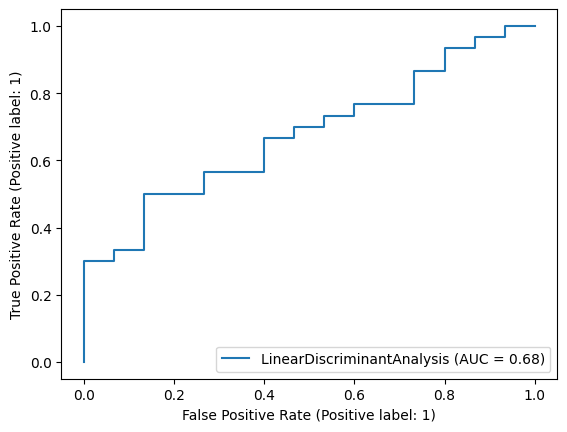

In [25]:
predict_model('LinearDiscriminantAnalysis', x_train, y_train, x_test, y_test)

LogisticRegression
Test data count:  45
accuracy_count:  26
f1_score:  0.6984126984126984
sensitivity_score:  0.7333333333333333
specificity_score:  0.26666666666666666
AUC: 0.6467


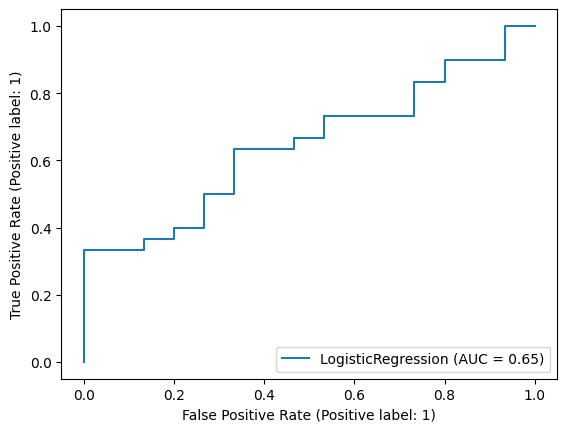

In [26]:
predict_model('LogisticRegression', x_train, y_train, x_test, y_test)

NeuralNetwork
Test data count:  45
accuracy_count:  30
f1_score:  0.761904761904762
sensitivity_score:  0.8
specificity_score:  0.4
AUC: 0.7267


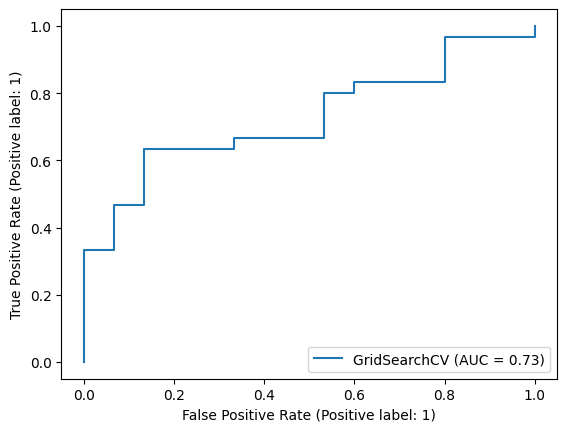

In [27]:
predict_model('NeuralNetwork', x_train, y_train, x_test, y_test)

SVM
Test data count:  45
accuracy_count:  27
f1_score:  0.71875
sensitivity_score:  0.7666666666666667
specificity_score:  0.26666666666666666
AUC: 0.6733


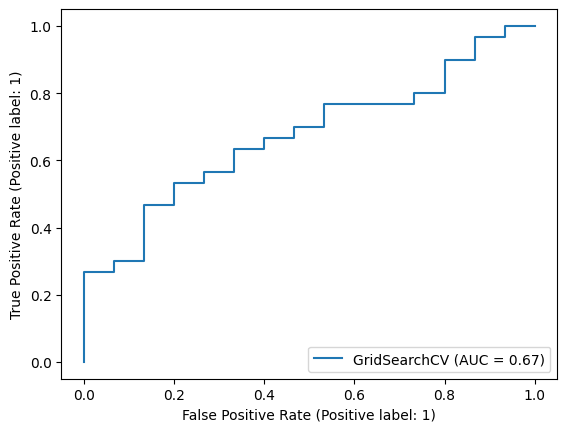

In [28]:
predict_model('SVM', x_train, y_train, x_test, y_test)

NaiveBayes
Test data count:  45
accuracy_count:  22
f1_score:  0.5660377358490566
sensitivity_score:  0.5
specificity_score:  0.4666666666666667
AUC: 0.5667


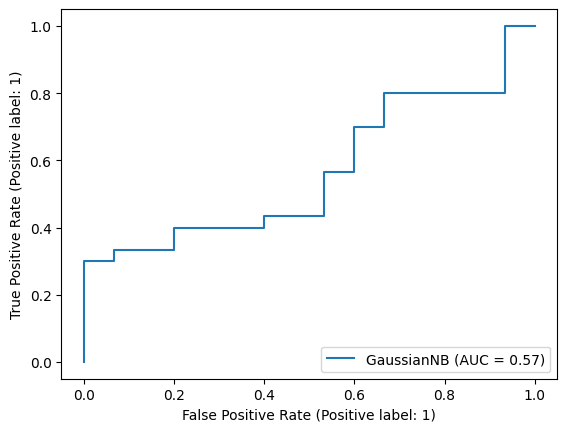

In [29]:
predict_model('NaiveBayes', x_train, y_train, x_test, y_test)

LADTree
Test data count:  45
accuracy_count:  22
f1_score:  0.5818181818181818
sensitivity_score:  0.5333333333333333
specificity_score:  0.4
AUC: 0.5533


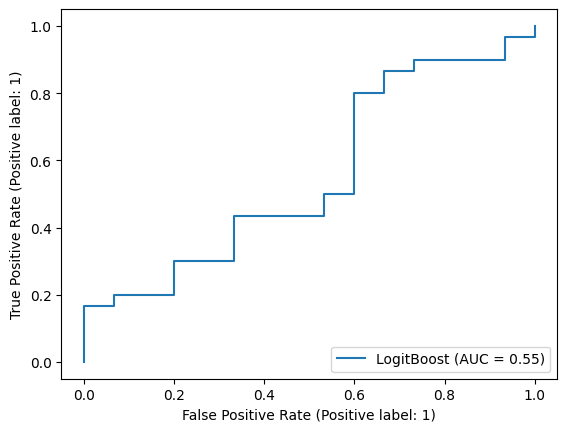

In [30]:
predict_model('LADTree', x_train, y_train, x_test, y_test)

RandomForest
Test data count:  45
accuracy_count:  27
f1_score:  0.71875
sensitivity_score:  0.7666666666666667
specificity_score:  0.26666666666666666
AUC: 0.6156


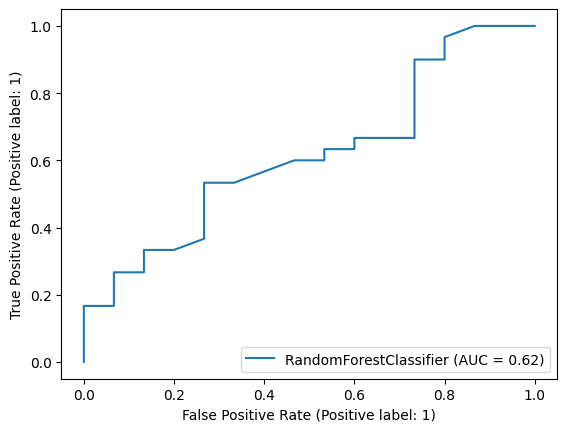

In [31]:
predict_model('RandomForest', x_train, y_train, x_test, y_test)

ElasticNet
Test data count:  45
accuracy_count:  29
f1_score:  0.7419354838709677
sensitivity_score:  0.7666666666666667
specificity_score:  0.4
AUC: 0.6622


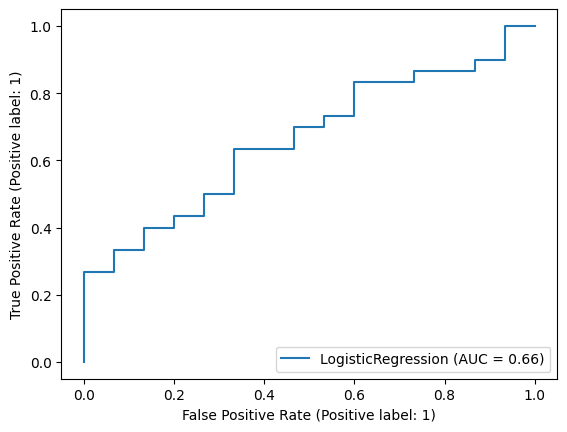

In [32]:
predict_model('ElasticNet', x_train, y_train, x_test, y_test)

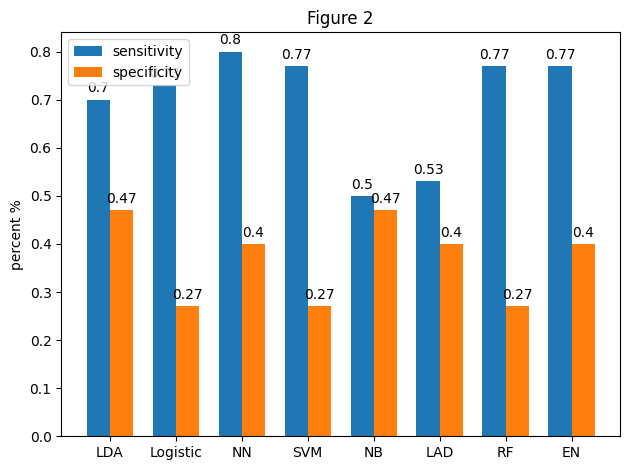

In [33]:
labels = ['LDA', 'Logistic', 'NN', 'SVM', 'NB', 'LAD', 'RF', 'EN']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, sensitivity_list, width, label='sensitivity')
rects2 = ax.bar(x + width/2, specificity_list, width, label='specificity')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('percent %')
ax.set_title('Figure 2')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [34]:
labels = ['LDA', 'Logistic', 'NN', 'SVM', 'NB', 'LAD', 'RF', 'EN']

if not os.path.isdir('../results/output/AUC'):
    os.mkdir('../results/output/AUC')

with open(f'../results/output/AUC/significance_based_AUC.csv', 'w') as f:
    f.write('model,AUC\n')
    for i in range(len(labels)):
        f.write(f"{labels[i]},{AUC_score[i]}\n")